In [ ]:
import os
import sys
import logging
from datetime import datetime
import asyncio
from arduino_iot_cloud import ArduinoCloudClient

# === CONFIG (your Manual/Python device creds) ===
DEVICE_ID  = "03f1bc3c-d0d3-49d7-b8d6-f10c9f686183"
SECRET_KEY = "BWK2OAz9MxQ9FynKfvIl4Advy"

LOG_DIR = "iot_logs"
PATHS = {v: os.path.join(LOG_DIR, f"{v}.csv") for v in ("x", "y", "z")}

logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(levelname)s: %(message)s")

def now_iso():
    return datetime.now().astimezone().isoformat(timespec="seconds")

def ensure_csv(path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    if not os.path.exists(path):
        with open(path, "a", encoding="utf-8", newline="") as f:
            f.write("timestamp,value\n")

def write_row(var_name, value):
    path = PATHS[var_name]
    ensure_csv(path)
    with open(path, "a", encoding="utf-8", newline="") as f:
        f.write(f"{now_iso()},{value}\n")
    logging.info(f"{var_name} -> {value} (saved to {os.path.relpath(path)})")

# --- callbacks (one per variable) ---
def on_x_changed(client, value): write_row("x", value)
def on_y_changed(client, value): write_row("y", value)
def on_z_changed(client, value): write_row("z", value)

async def run_client(client):
    # interval=1s poll; backoff=True enables auto-reconnect
    await client.run(interval=1, backoff=True)

def main():
    logging.info("Listening for x, y, z updates…")
    client = ArduinoCloudClient(device_id=DEVICE_ID, username=DEVICE_ID, password=SECRET_KEY)
    client.register("x", value=None, on_write=on_x_changed)
    client.register("y", value=None, on_write=on_y_changed)
    client.register("z", value=None, on_write=on_z_changed)

    # Terminal: no loop -> asyncio.run(...)
    # Jupyter: loop exists -> schedule task
    try:
        loop = asyncio.get_running_loop()
        loop.create_task(run_client(client))
        logging.info("Client scheduled on existing event loop.")
    except RuntimeError:
        asyncio.run(run_client(client))

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        logging.warning("Stopped by user.")
        sys.exit(0)
    except Exception:
        logging.exception("Fatal error")
        sys.exit(1)



[2025-09-16 09:59:02,973] INFO: Listening for x, y, z updates…
[2025-09-16 09:59:02,985] INFO: task: x created.
[2025-09-16 09:59:02,987] INFO: task: y created.
[2025-09-16 09:59:02,990] INFO: task: z created.
[2025-09-16 09:59:02,992] INFO: Client scheduled on existing event loop.


[2025-09-16 09:59:03,007] INFO: task: connection_task created.
[2025-09-16 09:59:03,009] INFO: Connecting to Arduino IoT cloud...
[2025-09-16 09:59:05,642] INFO: Subscribe: b'/a/d/03f1bc3c-d0d3-49d7-b8d6-f10c9f686183/e/i'.
[2025-09-16 09:59:06,807] INFO: task: discovery created.
[2025-09-16 09:59:06,810] INFO: task: mqtt_task created.


In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt

[2025-09-16 09:59:06,941] INFO: task: connection_task complete.


[2025-09-16 09:59:06,945] ERROR: task: mqtt_task raised exception: EOF occurred in violation of protocol (_ssl.c:2417).
[2025-09-16 09:59:06,947] INFO: task: connection_task created.
[2025-09-16 09:59:06,949] INFO: Connecting to Arduino IoT cloud...
[2025-09-16 09:59:10,045] INFO: Subscribe: b'/a/t/d63afcc2-012b-45d9-9368-cc6eff93d72f/e/i'.
[2025-09-16 09:59:10,667] INFO: task: mqtt_task created.


Combined CSV written: combined_accel_xyz.csv | Rows: 379 | Columns: ['timestamp', 'X', 'Y', 'Z']


,timestamp,X,Y,Z
0,2025-09-09 03:06:35.473610757+00:00,0.00000,2.38800,9.808950
1,2025-09-09 03:06:37.298951640+00:00,-0.42600,2.41200,9.349051
2,2025-09-09 03:06:38.323013602+00:00,-0.40905,2.33805,9.438001
3,2025-09-09 03:06:39.352968453+00:00,-0.57195,2.35200,9.423000
4,2025-09-09 03:06:40.368062202+00:00,-0.43800,2.35005,9.490050


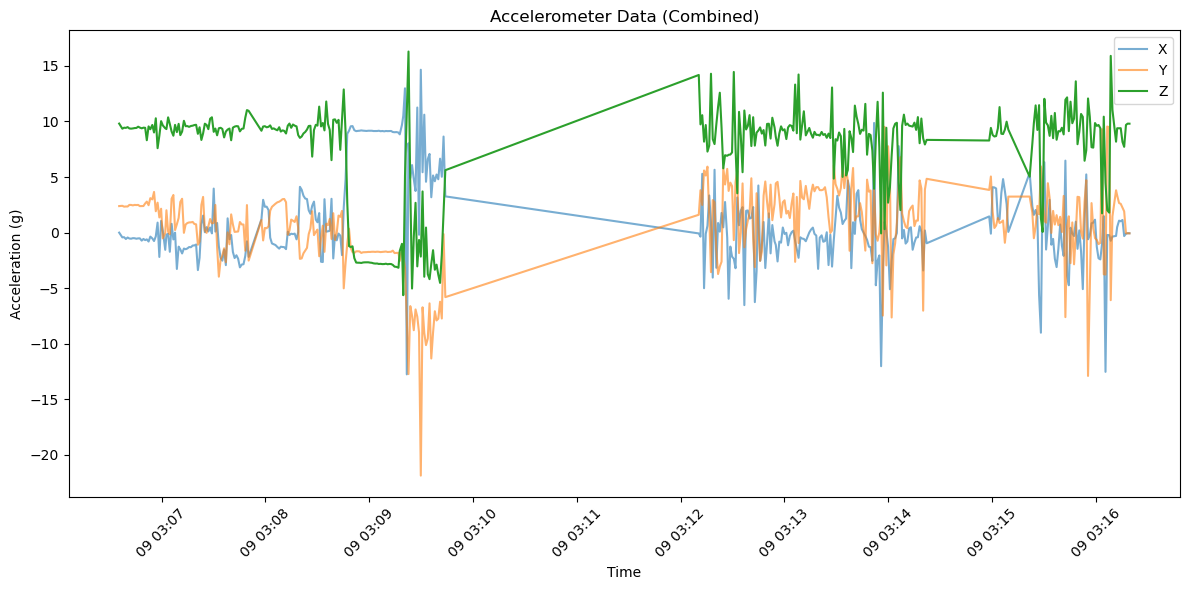

[2025-09-16 09:59:12,523] INFO: task: connection_task complete.


[2025-09-16 09:59:12,526] ERROR: task: mqtt_task raised exception: EOF occurred in violation of protocol (_ssl.c:2417).
[2025-09-16 09:59:12,527] INFO: task: connection_task created.
[2025-09-16 09:59:12,529] INFO: Connecting to Arduino IoT cloud...
[2025-09-16 09:59:14,877] INFO: Subscribe: b'/a/t/d63afcc2-012b-45d9-9368-cc6eff93d72f/e/i'.
[2025-09-16 09:59:15,562] INFO: task: mqtt_task created.


In [ ]:
# Load accelerometer CSVs and build a combined X/Y/Z file
import pandas as pd, os
import matplotlib.pyplot as plt

# Source file paths (adjust if different)
FILE_X = 'Xiaomi 13T Thing-Accelerometer_X.csv'
FILE_Y = 'Xiaomi 13T Thing-Accelerometer_Y.csv'
FILE_Z = 'Xiaomi 13T Thing-Accelerometer_Z.csv'
COMBINED_OUT = 'combined_accel_xyz.csv'

# Helper: load + standardise time column name to 'timestamp'
def load_and_standardise(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f'Missing file: {path}')
    df = pd.read_csv(path)
    # Try to find a time-like column
    for cand in ['timestamp', 'time', 'Time', 'Timestamp', 'date_time']:
        if cand in df.columns:
            if cand != 'timestamp':
                df.rename(columns={cand: 'timestamp'}, inplace=True)
            break
    else:
        raise KeyError(f'No time/timestamp column found in {path}. Columns: {df.columns.tolist()}')
    # If generic 'value' column exists keep as is; caller will rename after selection
    return df

df = load_and_standardise(FILE_X)
df_2 = load_and_standardise(FILE_Y)
df_3 = load_and_standardise(FILE_Z)

# Rename value columns (if they exist) so they do not collide when joined
if 'value' in df.columns: df.rename(columns={'value': 'X'}, inplace=True)
if 'value' in df_2.columns: df_2.rename(columns={'value': 'Y'}, inplace=True)
if 'value' in df_3.columns: df_3.rename(columns={'value': 'Z'}, inplace=True)

# Set index on timestamp for an outer join; preserves all timestamps that appear in any file
for d in (df, df_2, df_3):
    d['timestamp'] = pd.to_datetime(d['timestamp'], errors='coerce')
    d.set_index('timestamp', inplace=True)

# Select only the axis columns actually present (robust if source had extra columns)
cols_x = [c for c in df.columns if c == 'X']
cols_y = [c for c in df_2.columns if c == 'Y']
cols_z = [c for c in df_3.columns if c == 'Z']

combined = pd.concat([
    df[cols_x],
    df_2[cols_y],
    df_3[cols_z]
], axis=1).sort_index().reset_index()

# Save combined CSV
combined.to_csv(COMBINED_OUT, index=False)
print(f"Combined CSV written: {COMBINED_OUT} | Rows: {len(combined)} | Columns: {combined.columns.tolist()}")

# Quick preview
display(combined.head())

# Plot just Z (or others) as before if present
plt.figure(figsize=(12, 6))
if 'X' in combined.columns:
    plt.plot(combined['timestamp'], combined['X'], label='X', alpha=0.6)
if 'Y' in combined.columns:
    plt.plot(combined['timestamp'], combined['Y'], label='Y', alpha=0.6)
if 'Z' in combined.columns:
    plt.plot(combined['timestamp'], combined['Z'], label='Z')
plt.xlabel('Time')
plt.ylabel('Acceleration (g)')
plt.title('Accelerometer Data (Combined)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('graphs.png')
plt.show()

In [ ]:
# --- CELL 1: Listener + CSV + Snapshot ---

import os, csv, asyncio, threading, logging
from datetime import datetime
from collections import deque
from arduino_iot_cloud import ArduinoCloudClient

# ===== CONFIG =====
DEVICE_ID  = "03f1bc3c-d0d3-49d7-b8d6-f10c9f686183"   # Manual/Python device
SECRET_KEY = "BWK2OAz9MxQ9FynKfvIl4Advy"

RAW_DIR      = "iot_logs"     # raw streaming CSVs
SNAPSHOT_DIR = "snapshots"    # saved plots & snapshot CSVs (Cell 2 will use)
N_SNAPSHOT   = 1000           # choose your block size (e.g., ~10s worth)
MAX_BUFFER   = 10000          # rolling buffer capacity per axis

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(SNAPSHOT_DIR, exist_ok=True)

logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(levelname)s: %(message)s")

def _now_iso(): return datetime.now().astimezone().isoformat(timespec="seconds")

# ===== Continuous buffers (receive here) =====
rx_x = deque(maxlen=MAX_BUFFER)   # items: (timestamp, value)
rx_y = deque(maxlen=MAX_BUFFER)
rx_z = deque(maxlen=MAX_BUFFER)
buf_lock = threading.Lock()

# ===== Snapshot state (served to Cell 2 / Dash) =====
snapshot = {
    "x_ts": [], "x": [],
    "y_ts": [], "y": [],
    "z_ts": [], "z": [],
    "stamp": "",
}
snapshot_version = 0
snap_lock = threading.Lock()

# ===== Raw stream CSV append =====
def _append_raw(axis_name, ts, val):
    path = os.path.join(RAW_DIR, f"{axis_name}.csv")
    newfile = not os.path.exists(path)
    with open(path, "a", encoding="utf-8", newline="") as f:
        w = csv.writer(f)
        if newfile:
            w.writerow(["timestamp","value"])
        w.writerow([ts, val])

# ===== Push helpers + callbacks =====
def _push(axis_deque, axis_name, value):
    ts = _now_iso()
    try:
        v = float(value)
    except (TypeError, ValueError):
        v = value
    with buf_lock:
        axis_deque.append((ts, v))
    _append_raw(axis_name, ts, v)

def on_x_changed(client, value): _push(rx_x, "x", value)
def on_y_changed(client, value): _push(rx_y, "y", value)
def on_z_changed(client, value): _push(rx_z, "z", value)

# ===== Snapshot maker: move EXACTLY N_SNAPSHOT per axis out of rx_* =====
def try_make_snapshot():
    global snapshot_version, snapshot
    with buf_lock:
        if len(rx_x) < N_SNAPSHOT or len(rx_y) < N_SNAPSHOT or len(rx_z) < N_SNAPSHOT:
            return False
        xs = [rx_x.popleft() for _ in range(N_SNAPSHOT)]
        ys = [rx_y.popleft() for _ in range(N_SNAPSHOT)]
        zs = [rx_z.popleft() for _ in range(N_SNAPSHOT)]

    stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    with snap_lock:
        snapshot = {
            "x_ts": [t for t,_ in xs], "x": [v for _,v in xs],
            "y_ts": [t for t,_ in ys], "y": [v for _,v in ys],
            "z_ts": [t for t,_ in zs], "z": [v for _,v in zs],
            "stamp": stamp,
        }
        snapshot_version += 1
    logging.info(f"Snapshot #{snapshot_version} prepared ({N_SNAPSHOT} per axis)")
    return True

def _snapshot_worker():
    import time
    while True:
        made = try_make_snapshot()
        time.sleep(0.25 if not made else 0.01)

# ===== IoT client (runs on notebook loop) =====
_client_task = None
_client = None

async def _client_runner():
    global _client
    _client = ArduinoCloudClient(device_id=DEVICE_ID, username=DEVICE_ID, password=SECRET_KEY)
    _client.register("x", value=None, on_write=on_x_changed)
    _client.register("y", value=None, on_write=on_y_changed)
    _client.register("z", value=None, on_write=on_z_changed)
    logging.info("Listening… move x/y/z in Arduino IoT Remote.")
    await _client.run(interval=1, backoff=True)

def start_listener():
    global _client_task
    if _client_task and not _client_task.done():
        logging.info("Listener already running.")
        return
    _client_task = asyncio.create_task(_client_runner())
    threading.Thread(target=_snapshot_worker, daemon=True).start()
    logging.info("Listener + snapshot worker started.")

def stop_listener():
    global _client_task
    if _client_task and not _client_task.done():
        _client_task.cancel()
        logging.info("Listener task cancelled.")

# --- start once ---
start_listener()

# Optional: keep the cell alive while testing (uncomment to hold the cell)
# import asyncio
# await asyncio.sleep(3600)


[2025-09-16 09:59:15,668] INFO: Listener + snapshot worker started.


[2025-09-16 09:59:15,679] INFO: task: connection_task complete.
[2025-09-16 09:59:15,684] INFO: task: x created.
[2025-09-16 09:59:15,686] INFO: task: y created.
[2025-09-16 09:59:15,693] INFO: task: z created.
[2025-09-16 09:59:15,695] INFO: Listening… move x/y/z in Arduino IoT Remote.
[2025-09-16 09:59:15,699] INFO: task: connection_task created.
[2025-09-16 09:59:15,705] INFO: Connecting to Arduino IoT cloud...
[2025-09-16 09:59:18,829] INFO: Subscribe: b'/a/d/03f1bc3c-d0d3-49d7-b8d6-f10c9f686183/e/i'.
[2025-09-16 09:59:19,467] INFO: task: discovery created.
[2025-09-16 09:59:19,469] INFO: task: mqtt_task created.


In [ ]:
# --- CELL 2: Dash app that tails CSVs written by Cell 1 and saves snapshots ---

import os, csv, itertools
from datetime import datetime

import plotly.graph_objects as go
from dash import Dash, dcc, html, Output, Input, State

# Match Cell 1 paths
LOG_DIR = "iot_logs"
SNAPSHOT_DIR = "snapshots"
os.makedirs(SNAPSHOT_DIR, exist_ok=True)

# Choose block size (≈ number of fresh points per axis per refresh)
N_SNAPSHOT = 20

FILES = {
    "x": os.path.join(LOG_DIR, "x.csv"),
    "y": os.path.join(LOG_DIR, "y.csv"),
    "z": os.path.join(LOG_DIR, "z.csv"),
}

# In-memory "new data" buffers; each item: (timestamp_str, float_value)
new_x, new_y, new_z = [], [], []
# Track how many rows we've already consumed from each CSV
_offsets = {"x": 0, "y": 0, "z": 0}

def _tail_csv(axis: str):
    """Read newly appended rows from <axis>.csv since last offset."""
    path = FILES[axis]
    if not os.path.exists(path):
        return []
    with open(path, "r", encoding="utf-8") as f:
        rdr = csv.reader(f)
        data = list(rdr)
    if not data:
        return []

    # Skip header
    header_rows = 1
    if _offsets[axis] < header_rows:
        _offsets[axis] = header_rows

    rows = []
    if _offsets[axis] < len(data):
        for r in itertools.islice(data, _offsets[axis], None):
            if len(r) >= 2:
                ts, val = r[0], r[1]
                try:
                    v = float(val)
                except:
                    continue
                rows.append((ts, v))
        _offsets[axis] = len(data)
    return rows

def _figure(ts, vals, label):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ts, y=vals, mode="lines", name=label))
    fig.update_layout(
        template="plotly_white",
        margin=dict(l=50, r=30, t=40, b=40),
        xaxis_title="Time", yaxis_title=f"{label} value"
    )
    return fig

def _save_snapshot_csv(base, ts, vals):
    path = os.path.join(SNAPSHOT_DIR, f"{base}.csv")
    with open(path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["timestamp","value"])
        w.writerows(zip(ts, vals))
    return path

app = Dash(__name__)
app.layout = html.Div([
    html.H3("Gyro snapshots from CSV (x, y, z)"),
    html.Div("App updates only when N_SNAPSHOT fresh points per axis are available."),
    html.Div(id="meta", style={"marginBottom":"8px"}),
    dcc.Store(id="served_count", data=0),
    dcc.Interval(id="tick", interval=1000, n_intervals=0),  # poll every 1s
    dcc.Graph(id="gx"),
    dcc.Graph(id="gy"),
    dcc.Graph(id="gz"),
])

@app.callback(
    Output("gx","figure"),
    Output("gy","figure"),
    Output("gz","figure"),
    Output("meta","children"),
    Output("served_count","data"),
    Input("tick","n_intervals"),
    State("served_count","data"),
    prevent_initial_call=False
)
def refresh(_n, served_count):
    # 1) Read any newly appended rows since last tick
    rows_x = _tail_csv("x")
    rows_y = _tail_csv("y")
    rows_z = _tail_csv("z")
    if rows_x: new_x.extend(rows_x)
    if rows_y: new_y.extend(rows_y)
    if rows_z: new_z.extend(rows_z)

    # 2) If enough fresh data per axis, pop exactly N_SNAPSHOT (no repeats)
    if len(new_x) < N_SNAPSHOT or len(new_y) < N_SNAPSHOT or len(new_z) < N_SNAPSHOT:
        return go.Figure(), go.Figure(), go.Figure(), \
               f"Waiting for N={N_SNAPSHOT} new samples per axis… served={served_count or 0}", \
               served_count

    xs = new_x[:N_SNAPSHOT]; del new_x[:N_SNAPSHOT]
    ys = new_y[:N_SNAPSHOT]; del new_y[:N_SNAPSHOT]
    zs = new_z[:N_SNAPSHOT]; del new_z[:N_SNAPSHOT]

    x_ts, x_vals = zip(*xs)
    y_ts, y_vals = zip(*ys)
    z_ts, z_vals = zip(*zs)

    # 3) Build figures
    fig_x = _figure(x_ts, x_vals, "x")
    fig_y = _figure(y_ts, y_vals, "y")
    fig_z = _figure(z_ts, z_vals, "z")

    # 4) Save PNGs + CSVs with timestamp
    stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_x = f"x_{stamp}"; base_y = f"y_{stamp}"; base_z = f"z_{stamp}"

    _save_snapshot_csv(base_x, x_ts, x_vals)
    _save_snapshot_csv(base_y, y_ts, y_vals)
    _save_snapshot_csv(base_z, z_ts, z_vals)

    try:
        fig_x.write_image(os.path.join(SNAPSHOT_DIR, f"{base_x}.png"), scale=2, width=1000, height=400)
        fig_y.write_image(os.path.join(SNAPSHOT_DIR, f"{base_y}.png"), scale=2, width=1000, height=400)
        fig_z.write_image(os.path.join(SNAPSHOT_DIR, f"{base_z}.png"), scale=2, width=1000, height=400)
        note = "Saved PNGs + CSVs."
    except Exception as e:
        note = f"Saved CSVs; PNG save skipped ({e})."

    served_count = (served_count or 0) + 1
    meta = f"Snapshot #{served_count} @ {stamp} | N={N_SNAPSHOT}. {note}"
    return fig_x, fig_y, fig_z, meta, served_count

if __name__ == "__main__":
    # Run on localhost; open http://127.0.0.1:8050 in your browser
    app.run(host="127.0.0.1", port=8050, debug=False)


[2025-09-16 09:59:19,836] INFO: task: connection_task complete.


## Samples saved into snapshots and different csv

In [17]:
import pandas as pd
import plotly.graph_objects as go
import os

# Parameters
N_SNAPSHOT = 10  # Number of samples per activity
DATA_PATH = "iot_logs/z.csv"
SNAPSHOT_DIR = "snapshots"
os.makedirs(SNAPSHOT_DIR, exist_ok=True)

# Load all data
df = pd.read_csv(DATA_PATH)
buffer_live = list(zip(df['timestamp'], df['value']))
snapshots = []

def save_and_plot_snapshot(snapshot, idx):
    ts, vals = zip(*snapshot)
    # Save to CSV
    out_df = pd.DataFrame({'timestamp': ts, 'value': vals})
    csv_path = os.path.join(SNAPSHOT_DIR, f"activity_{idx+1}.csv")
    out_df.to_csv(csv_path, mode='a', header=not os.path.exists(csv_path), index=False)
    print(f"Saved: {csv_path}")
    # Plot

    fig = go.Figure(data=go.Scatter(x=ts, y=vals, mode='lines'))
    fig.update_layout(title=f"Activity {idx+1} ({N_SNAPSHOT} samples)")
    fig.show()

# Split buffer_live into snapshots of N_SNAPSHOT samples
for i in range(0, len(buffer_live), N_SNAPSHOT):
    snapshot = buffer_live[i:i+N_SNAPSHOT]
    if len(snapshot) == N_SNAPSHOT:
        snapshots.append(snapshot)

# Save and plot each activity
for idx, snapshot in enumerate(snapshots):
    save_and_plot_snapshot(snapshot, idx)

Saved: snapshots\activity_1.csv


Saved: snapshots\activity_2.csv


Saved: snapshots\activity_3.csv


Saved: snapshots\activity_4.csv


Saved: snapshots\activity_5.csv


Saved: snapshots\activity_6.csv


Saved: snapshots\activity_7.csv


Saved: snapshots\activity_8.csv


Saved: snapshots\activity_9.csv


Saved: snapshots\activity_10.csv


Saved: snapshots\activity_11.csv


Saved: snapshots\activity_12.csv


Saved: snapshots\activity_13.csv


Saved: snapshots\activity_14.csv


Saved: snapshots\activity_15.csv


Saved: snapshots\activity_16.csv


Saved: snapshots\activity_17.csv


Saved: snapshots\activity_18.csv


Saved: snapshots\activity_19.csv


Saved: snapshots\activity_20.csv


Saved: snapshots\activity_21.csv


Saved: snapshots\activity_22.csv


Saved: snapshots\activity_23.csv


Saved: snapshots\activity_24.csv


Saved: snapshots\activity_25.csv


Saved: snapshots\activity_26.csv


Saved: snapshots\activity_27.csv


Saved: snapshots\activity_28.csv


Saved: snapshots\activity_29.csv


Saved: snapshots\activity_30.csv


Saved: snapshots\activity_31.csv


Saved: snapshots\activity_32.csv


Saved: snapshots\activity_33.csv


Saved: snapshots\activity_34.csv


Saved: snapshots\activity_35.csv


Saved: snapshots\activity_36.csv


Saved: snapshots\activity_37.csv


Saved: snapshots\activity_38.csv


Saved: snapshots\activity_39.csv


Saved: snapshots\activity_40.csv


Saved: snapshots\activity_41.csv


Saved: snapshots\activity_42.csv


Saved: snapshots\activity_43.csv


Saved: snapshots\activity_44.csv


[2025-09-16 09:59:24,809] INFO: Subscribe: b'/a/t/d63afcc2-012b-45d9-9368-cc6eff93d72f/e/i'.


[2025-09-16 09:59:25,578] INFO: Subscribe: b'/a/t/d63afcc2-012b-45d9-9368-cc6eff93d72f/shadow/i'.
[2025-09-16 09:59:27,272] INFO: Device configured via discovery protocol.


## Live plotly dash graph

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from dash import Dash, dcc, html, Output, Input, State

app = Dash(__name__)

app.layout = html.Div([
    dcc.Interval(id="tick", interval=1000, n_intervals=0),
    dcc.Store(id="served_count", data=0),
    html.Div(id="meta"),
    dcc.Graph(id="gx"),
    dcc.Graph(id="gy"),
    dcc.Graph(id="gz"),
])

@app.callback(
    Output("gx", "figure"),
    Output("gy", "figure"),
    Output("gz", "figure"),
    Output("meta", "children"),
    Output("served_count", "data"),
    Input("tick", "n_intervals"),
    State("served_count", "data"),
    prevent_initial_call=False
)
def refresh(n_intervals, served_count):
    # Example: load CSVs and plot
    df_x = pd.read_csv("iot_logs/x.csv")
    df_y = pd.read_csv("iot_logs/y.csv")
    df_z = pd.read_csv("iot_logs/z.csv")
    fig_x = go.Figure(data=go.Scatter(x=df_x['timestamp'], y=df_x['value'], mode='lines'))
    fig_y = go.Figure(data=go.Scatter(x=df_y['timestamp'], y=df_y['value'], mode='lines'))
    fig_z = go.Figure(data=go.Scatter(x=df_z['timestamp'], y=df_z['value'], mode='lines'))
    meta = f"Refreshed at interval {n_intervals}"
    served_count = (served_count or 0) + 1
    return fig_x, fig_y, fig_z, meta, served_count

if __name__ == "__main__":
    app.run(debug=True)

[2025-09-16 09:59:28,102] INFO: task: discovery complete.
[2025-09-16 09:59:28,104] ERROR: task: mqtt_task raised exception: EOF occurred in violation of protocol (_ssl.c:2417).
[2025-09-16 09:59:28,106] INFO: task: connection_task created.
[2025-09-16 09:59:28,108] ERROR: task: mqtt_task raised exception: EOF occurred in violation of protocol (_ssl.c:2417).
[2025-09-16 09:59:28,110] INFO: task: connection_task created.
[2025-09-16 09:59:28,112] INFO: Connecting to Arduino IoT cloud...
[2025-09-16 09:59:30,882] INFO: Subscribe: b'/a/t/d63afcc2-012b-45d9-9368-cc6eff93d72f/e/i'.
[2025-09-16 09:59:31,617] INFO: task: mqtt_task created.
[2025-09-16 09:59:31,620] INFO: Connecting to Arduino IoT cloud...
[2025-09-16 09:59:33,782] INFO: Subscribe: b'/a/t/d63afcc2-012b-45d9-9368-cc6eff93d72f/e/i'.
[2025-09-16 09:59:34,367] INFO: task: mqtt_task created.


In [ ]:
# Utility: build a live combined CSV from iot_logs streaming files
import pandas as pd, os
LIVE_COMBINED = 'live_combined_xyz.csv'
LOG_DIR = 'iot_logs'
files = {
    'x': os.path.join(LOG_DIR, 'x.csv'),
    'y': os.path.join(LOG_DIR, 'y.csv'),
    'z': os.path.join(LOG_DIR, 'z.csv'),
}
series = []
for axis, path in files.items():
    if not os.path.exists(path):
        print(f'Skip missing {path}')
        continue
    df_axis = pd.read_csv(path)
    if 'timestamp' not in df_axis.columns or 'value' not in df_axis.columns:
        print(f'Skip malformed {path} cols={df_axis.columns.tolist()}')
        continue
    df_axis['timestamp'] = pd.to_datetime(df_axis['timestamp'], errors='coerce')
    df_axis = df_axis.drop_duplicates(subset='timestamp', keep='last')

    s = df_axis.set_index('timestamp')['value'].rename(axis.upper())
    series.append(s)

if not series:
    print('No valid axis files to combine yet.')
else:
    live = pd.concat(series, axis=1).sort_index().reset_index()
    live.to_csv(LIVE_COMBINED, index=False)
    print(f'Live combined written: {LIVE_COMBINED} rows={len(live)} cols={live.columns.tolist()}')
    display(live.tail())

Live combined written: live_combined_xyz.csv rows=1349 cols=['timestamp', 'X', 'Y', 'Z']


,timestamp,X,Y,Z
1344,2025-09-16 09:58:17+10:00,0.01395,NaN,NaN
1345,2025-09-16 09:58:18+10:00,NaN,-0.03600,NaN
1346,2025-09-16 09:58:19+10:00,NaN,NaN,9.81105
1347,2025-09-16 09:58:20+10:00,0.02595,NaN,NaN
1348,2025-09-16 09:59:27+10:00,-0.00705,-0.02205,9.82305


[2025-09-16 10:02:20,376] ERROR: task: mqtt_task raised exception: EOF occurred in violation of protocol (_ssl.c:2417).
[2025-09-16 10:02:20,378] INFO: task: connection_task created.
[2025-09-16 10:02:20,379] INFO: Connecting to Arduino IoT cloud...
[2025-09-16 10:02:22,461] INFO: Subscribe: b'/a/t/d63afcc2-012b-45d9-9368-cc6eff93d72f/e/i'.
[2025-09-16 10:02:22,920] INFO: task: mqtt_task created.
[2025-09-16 10:02:22,985] INFO: task: connection_task complete.
[2025-09-16 10:02:26,125] ERROR: task: mqtt_task raised exception: EOF occurred in violation of protocol (_ssl.c:2417).
[2025-09-16 10:02:26,127] INFO: task: connection_task created.
[2025-09-16 10:02:26,128] INFO: Connecting to Arduino IoT cloud...
[2025-09-16 10:02:28,436] INFO: Subscribe: b'/a/t/d63afcc2-012b-45d9-9368-cc6eff93d72f/e/i'.
[2025-09-16 10:02:28,896] INFO: task: mqtt_task created.
[2025-09-16 10:02:28,951] INFO: task: connection_task complete.
[2025-09-16 10:02:31,024] ERROR: task: mqtt_task raised exception: EOF o